# Préliminaires 

## Récupération des bibliothèques

In [1]:
# Basics
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from urllib import request
import time

# Image rendering
from PIL import Image, ImageFilter
import ipyplot

# Machine learning
from sklearn.datasets import fetch_openml
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn import neighbors
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

## Mise en place des styles

In [2]:
plt.style.use('seaborn-whitegrid')
sns.set_style('whitegrid')

## Récupération des données

In [3]:
url = 'https://github.com/amplab/datascience-sp14/raw/master/lab7/mldata/mnist-original.mat'
#request.urlretrieve (url, "./openml/mnist-original.mat")

## Préparation des fonctions de base

In [4]:
def fetch_data(database):
    mnist = fetch_openml(database, version=1)
    data = mnist.data
    labels = mnist.target
    framesize = 28
    return data, labels, framesize

In [5]:
def split_data(data,labels,n_split,n_train,n_test,rand_state,details=True):
    res = []
    sss = StratifiedShuffleSplit(n_splits=n_split, test_size=n_test,train_size=n_train, random_state=rand_state)
    for train_index, test_index in sss.split(data, labels):
        train = [data[train_index],labels[train_index]]
        test = [data[test_index],labels[test_index]]
        res.append([train,test])
    if details:    
        print("results shape:",np.array(res).shape)
        print("train label size:",res[3][0][0].shape," - train data size:",res[3][0][1].shape)
        print("test label size:",res[3][1][0].shape," - test data size:",res[3][1][1].shape)

    return np.array(res)

In [6]:
#data, labels, framesize = fetch_data('mnist_784')

In [7]:
#res = split_data(data,labels,5,100,10,69)

# Optimisaton de l'hyperparamètre "k"

On prend un échantillon de taille arbitraire et on applique l'algorithme k-NN avec plusieurs valeurs de $k$. 
<br>On affiche ensuite l'erreur et le temps de calcul pour chaque valeur de $k$ afin d'identifier la configuration optimum du modèle.

In [8]:
# Chargement des données
start_time = time.time()
data, labels, framesize = fetch_data('mnist_784')
print("loading time: %.2fs" %(time.time() - start_time))

loading time: 25.14s


In [9]:
# Échantillonnage 
k_params = np.linspace(1,10,10).astype('int')
n_train = 5000
n_test = 100
print("K=:",k_params)
samples = split_data(data,labels,len(k_params),n_train,n_test,59)

K=: [ 1  2  3  4  5  6  7  8  9 10]
results shape: (10, 2, 2)
train label size: (5000, 784)  - train data size: (5000,)
test label size: (100, 784)  - test data size: (100,)


In [10]:
# Résultats attendus
errors = []
executions = []

# Réalisation d'un k-NN pour chacune des valeurs de k dans k_params
for i in range(len(k_params)):
    # Mesure du temps d'exécution
    start_time = time.time()
    # Application du modèle k-NN
    knn_i = neighbors.KNeighborsClassifier(n_neighbors=k_params[i], n_jobs=-1)
    knn_i.fit(samples[i][0][0], samples[i][0][1])
    # Mesure de l'erreur et du temps
    errors.append(100*(1 - knn_i.score(samples[i][1][0], samples[i][1][1])))
    executions.append((time.time() - start_time))

# Affichage des résultats préliminaires
#print(["%.2f%%" % (error) for error in errors])
#print(["%.3fs" % (time) for time in executions])

# Présentation des résultats dans un tableau
results_data = pd.DataFrame({'k':k_params,
                            'error (%)':errors,
                            'time (s)':executions})
print("Execution time: %.2f seconds" %(np.sum(executions)))
results_data.set_index('k', inplace=True)
results_data

Execution time: 12.33 seconds


,error (%),time (s)
k,,
1,6.0,1.375253
2,11.0,1.350346
3,7.0,1.169861
4,6.0,1.103872
5,4.0,1.059104
6,5.0,0.935786
7,9.0,1.775705
8,7.0,0.974733
9,6.0,1.227533


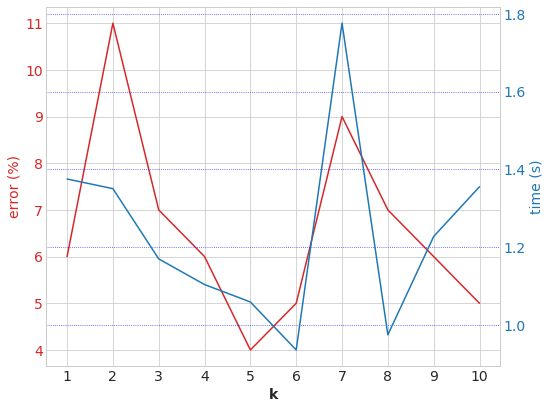

In [11]:
# Affichage
mpl.rcParams["font.size"] = 14
fig, ax1 = plt.subplots(figsize=(20.0/2.54, 15.0/2.54))

color = 'tab:red'
ax1.set_xlabel(results_data.index.name,fontdict=dict(weight='bold'))
ax1.set_ylabel(results_data.columns[0], color=color)
ax1.plot(results_data.index.values, results_data[results_data.columns[0]].values, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(linestyle='-')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel(results_data.columns[1], color=color)  # we already handled the x-label with ax1
ax2.plot(results_data.index.values, results_data[results_data.columns[1]].values, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.grid(linestyle=':',color='b',alpha=0.8)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.xticks(results_data.index.values)
plt.show()

**Conclusion**
<br>Il ne semble pas y avoir un choix de paramètre $k$ extrêmement plus avantageux qu'un autre. L'effet de l'échantillonnage sur l'erreur et le temps de calcul semble dépasser largement l'effet du paramètre $k$.
<br>L'optimum pour le paramètre k semble être quelque part entre $k=3$ et $k=5$.

# Analyse avancée

## Calcul de l'erreur et du temps d'exécution sur un espace plus large

In [12]:
# Chargement des données
start_time = time.time()
data, labels, framesize = fetch_data('mnist_784')
print("loading time: %.2fs" %(time.time() - start_time))

loading time: 24.36s


In [13]:
# Constructon de l'espace à explorer
k_min = 1
k_max = 10
n_samples = 20 # nb d'échantillon à analyser pour chaque valeur de k
sample_type = 'lin'  # type of sample ('lin','log)
n_train_min = 250
n_train_max = 5000
n_test_min = 50
n_test_max = 1000

# Vecteur K
k_params = np.linspace(k_min,k_max,k_max-k_min+1).astype('int') # k = [1,2,4,...]
# Vecteur taille de l'échantillon
if sample_type == 'lin':
    # Échelle linéaire
    n_train = np.linspace(n_train_min,n_train_max,num=n_samples,dtype='int') 
    n_test = np.linspace(n_test_min,n_test_max,num=n_samples,dtype='int') 
elif sample_type == 'log':
    # Échelle logarithmique
    n_train = np.geomspace(n_train_min,n_train_max,num=n_samples,dtype='int') 
    n_test = np.geomspace(n_test_min,n_test_max,num=n_samples,dtype='int') 
else :
    raise Exception('value of sample type not expected : "%s"' %(sample_type))

print("K:\n", k_params)
print("Training sample sizes:\n", n_train)
print("Testing sample sizes:\n", n_test)

K:
 [ 1  2  3  4  5  6  7  8  9 10]
Training sample sizes:
 [ 250  500  750 1000 1250 1500 1750 2000 2250 2500 2750 3000 3250 3500
 3750 4000 4250 4500 4750 5000]
Testing sample sizes:
 [  50  100  150  200  250  300  350  400  450  500  550  600  650  700
  750  800  850  900  950 1000]


In [14]:
# Réalisation des simulations
start_time = time.time()
results = np.zeros((len(k_params),2,n_samples)) # results = [k_value,error/test,value]
for j in range(n_samples):
    # Génération des échantillons
    samples = split_data(data,labels,len(k_params),n_train[j],n_test[j],81,False)
    for i in range(len(k_params)):
        print("sample:",'%02d/%02d' %(j+1,n_samples),"- k:",'%02d/%02d' %(i+1,len(k_params)),end='\r',flush=True)
        # Mesure du temps d'exécution
        loop_start_time = time.time()
        # Application du modèle k-NN
        knn = neighbors.KNeighborsClassifier(n_neighbors=k_params[i], n_jobs=-1)
        knn.fit(samples[i][0][0], samples[i][0][1])
        # Mesure de l'erreur et du temps
        results[i,0,j] = 100*(1 - knn.score(samples[i][1][0], samples[i][1][1]))
        results[i,1,j] = time.time() - loop_start_time
print("execution time: %.2fs" %(time.time() - start_time))

execution time: 327.62s0


## Effet de la valeur k sur l'erreur et le temps de calcul pour plusieurs échantillons de tailles différentes

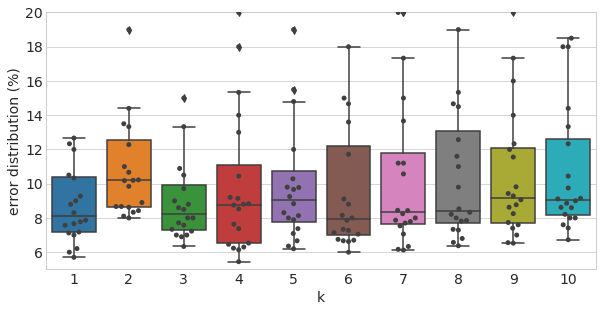

In [15]:
# Visualisation de l'erreur en fonction de k
plt.figure(figsize=(25.0/2.54, 12.0/2.54))
g1 = sns.boxplot(data=results[:,0,:].T)
g2 = sns.swarmplot(data=results[:,0,:].T, color=".25")
g1.set_xticks(range(len(k_params)))
g1.set_xticklabels(k_params.astype(str))
g1.set(ylim=(5,20))
plt.xlabel("k")
plt.ylabel("error distribution (%)")
plt.show()

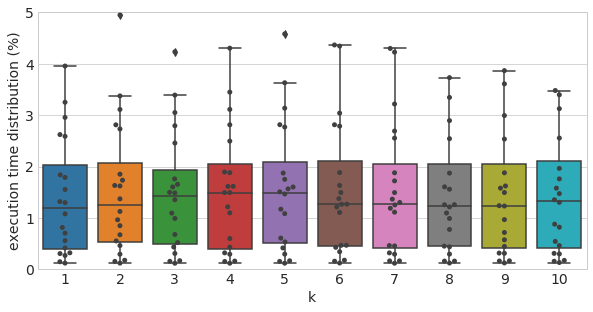

In [16]:
# Visualisation du temps d'exécution en fonction de k
plt.figure(figsize=(25.0/2.54, 12.0/2.54))
g1 = sns.boxplot(data=results[:,1,:].T)
g2 = sns.swarmplot(data=results[:,1,:].T, color=".25")
g1.set_xticks(range(len(k_params)))
g1.set_xticklabels(k_params.astype(str))
g1.set(ylim=(0,5))
plt.xlabel("k")
plt.ylabel("execution time distribution (%)")
plt.show()

**Les résultats ne sont vraiment pas probants.**
<br> La valeur de k n'influe quasiment pas sur le temps d'exécution et l'effet sur l'erreur est vraiment minime. 
<br>Il semble que le résultat reste le même que pour le calcul sur un échantillon de taille fixe, à savoir que l'optimum se trouve entre $k=4$ et $k=5$.

## Effet de la taille de l'échantillon sur l'erreur et le temps de calcul

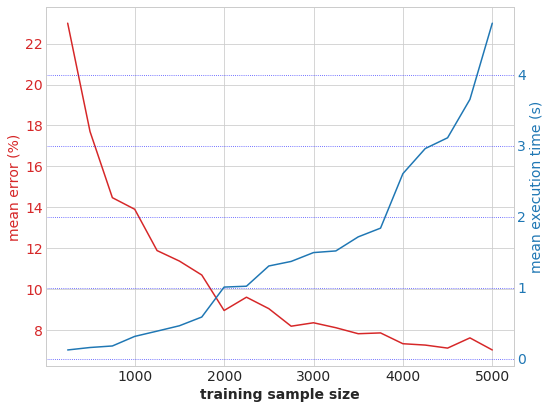

In [17]:
# Visualisation de l'effet de la taille de l'échantillon sur l'erreur et le temps d'exécution
mean_sample_results = np.mean(results,axis=0)

mpl.rcParams["font.size"] = 14
fig, ax1 = plt.subplots(figsize=(20.0/2.54, 15.0/2.54))

color = 'tab:red'
ax1.set_xlabel('training sample size',fontdict=dict(weight='bold'))
ax1.set_ylabel('mean error (%)', color=color)
ax1.plot(n_train, mean_sample_results[0,:], color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(linestyle='-')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('mean execution time (s)', color=color)  # we already handled the x-label with ax1
ax2.plot(n_train, mean_sample_results[1,:], color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.grid(linestyle=':',color='b',alpha=0.8)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

Nous observons une croissance exponentielle (quasiment linéaire) du temps de calcul en fonction de la taille de l'échantillon.
<br>Nous observons une relation inversement proportionnelle (quasiment exponentielle) entre l'erreur est la taille de l'échantillon. 
<br>
<br>Dans la prochaine étape nous cherchons à caractériser plus précisemment ces relations à partir d'une régression linéaire.

## Relation entre taille d'échantillon erreur et temps de calcul

### Régression linéaire sur modèle exponentiel pour le temps de calcul

In [18]:
# Passage par le logarithme pour linéariser le problème
lnT = np.log(mean_sample_results[1,:])
regT = LinearRegression().fit(n_train.reshape(-1,1),lnT)

TP = np.exp(regT.intercept_)*np.exp(regT.coef_*n_train)

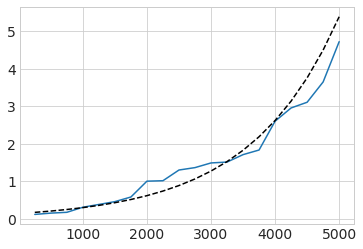

Ypredicted = 0.15*e^(0.000720*X)
r2_time = 0.9491104952986646


In [20]:
plt.plot(n_train,mean_sample_results[1,:])
plt.plot(n_train,TP,color='k',linestyle='--')
plt.show()

print('Ypredicted = %.2f*e^(%.6f*X)' %(np.exp(regT.intercept_),regT.coef_))
print('r2_time =', r2_score(TP,mean_sample_results[1,:]))

### Régression linéaire sur modèle exponentiel pour l'erreur

Utilisation de la méthode matricielle en considérant une modèle inversement proportionnel, soit :
<br>
<br><center>${\hat y_{i}} = {x_{i}}^{0}.\theta_{0} + {x_{i}}^{-1}.\theta_{1} = \theta_{0} + {\frac {\theta_{1}}{x_{i}}}$</center>


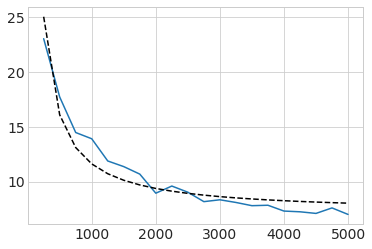

Ypredicted = 4461.01/X + 7.15
r2_error = 0.9283056945920013
error min = 7.15 %


In [21]:
# Méthode matricielle
X = np.column_stack((n_train**0, 1/n_train)) # Génération de la base du modèle
theta =  np.linalg.inv(X.T.dot(X)).dot(X.T).dot(mean_sample_results[0,:]) # Sol. analytique
EP = theta[0] + theta[1]/n_train

plt.plot(n_train,mean_sample_results[0,:])
plt.plot(n_train,EP,color='k',linestyle='--')
plt.show()

print('Ypredicted = %.2f/X + %.2f' %(theta[1],theta[0]))
print('r2_error =', r2_score(mean_sample_results[0,:],EP))
print('error min = %.2f' %(theta[0]),'%')

### Synthèse

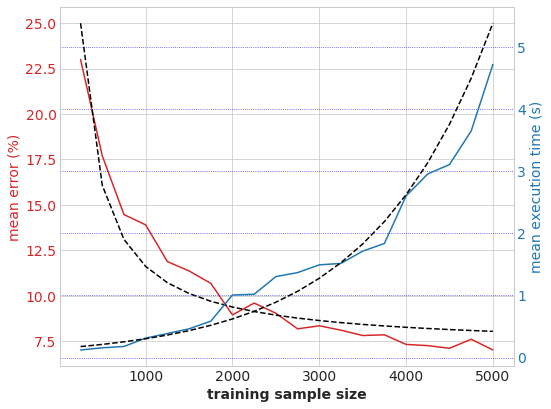

In [23]:
mpl.rcParams["font.size"] = 14
fig, ax1 = plt.subplots(figsize=(20.0/2.54, 15.0/2.54))

color = 'tab:red'
ax1.set_xlabel('training sample size',fontdict=dict(weight='bold'))
ax1.set_ylabel('mean error (%)', color=color)
ax1.plot(n_train, mean_sample_results[0,:], color=color)
ax1.plot(n_train, EP,color='k',linestyle='--')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(linestyle='-')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('mean execution time (s)', color=color)  # we already handled the x-label with ax1
ax2.plot(n_train, mean_sample_results[1,:], color=color)
ax2.plot(n_train, TP,color='k',linestyle='--')
ax2.tick_params(axis='y', labelcolor=color)
ax2.grid(linestyle=':',color='b',alpha=0.8)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

# Effet du pré-traitement

Grâce à l'étude précédente, on fixe les paramètres suivants :
* $k = 5$
* $n_{training} = 10000 $
* $n_{testing} = 1000 $

<br>L'objectif est d'identifier l'effet d'un pré-traitement d'une image sur la performance du modèle. 
<br>Les effets sont déjà implémentés dans PIL.ImageFilter :
* GAUSSIANBLUR (rend les images plus floues)
* CONTOUR (fait ressortir les contours)
* EMBOSS (fait ressortir les contours dans la direction verticale)

## Mise en place du pré-traitement

In [24]:
# Chargement des données
start_time = time.time()
data, labels, framesize = fetch_data('mnist_784')
print("loading time: %.2fs" %(time.time() - start_time))

loading time: 26.35s


In [25]:
# Paramètres
k = 5
n_train = 10000
n_test = 1000

In [26]:
# Visualisation de l'effet des filtres
rand_int = np.random.randint(data.shape[0])
rand_arr = data[rand_int,:].reshape(framesize,framesize)

rand_img = Image.fromarray(np.uint8(rand_arr),'L')
blur_img = rand_img.filter(ImageFilter.GaussianBlur(radius=1.2))
contour_img = rand_img.filter(ImageFilter.CONTOUR)
emboss_img = rand_img.filter(ImageFilter.EMBOSS)

display(rand_img)
display(blur_img)
display(contour_img)
display(emboss_img)

## Comparaison des pré-traitements

In [27]:
# Échantillonnage
sample = split_data(data,labels,1,n_train,n_test,63,False).squeeze()

In [28]:
# Traitement (filtrage des images)
base_data = []
blur_data = []
contour_data = []
emboss_data = []


for i in range(len(sample[0,0])):
    base_arr = sample[0,0][i].reshape(framesize,framesize)
    
    base_img = Image.fromarray(np.uint8(base_arr),'L')
    blur_img = base_img.filter(ImageFilter.GaussianBlur(radius=1.2))
    contour_img = base_img.filter(ImageFilter.CONTOUR)
    emboss_img = base_img.filter(ImageFilter.EMBOSS)
    
    base_data.append(np.array(base_img).reshape(-1,1).squeeze())
    blur_data.append(np.array(blur_img).reshape(-1,1).squeeze())
    contour_data.append(np.array(contour_img).reshape(-1,1).squeeze())
    emboss_data.append(np.array(emboss_img).reshape(-1,1).squeeze())

In [29]:
start_time = time.time()

# Baseline
knn_5 = neighbors.KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
knn_5.fit(base_data, sample[0][1])
print('base score = %.2f'%(100*(1 - knn_5.score(sample[1][0], sample[1][1]))),'%')

# Blur
knn_5 = neighbors.KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
knn_5.fit(blur_data, sample[0][1])
print('blur score = %.2f'%(100*(1 - knn_5.score(sample[1][0], sample[1][1]))),'%')

# Baseline
knn_5 = neighbors.KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
knn_5.fit(contour_data, sample[0][1])
print('contour score = %.2f'%(100*(1 - knn_5.score(sample[1][0], sample[1][1]))),'%')

# Baseline
knn_5 = neighbors.KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
knn_5.fit(emboss_data, sample[0][1])
print('emboss score = %.2f'%(100*(1 - knn_5.score(sample[1][0], sample[1][1]))),'%')

print('')
print("execution time: %.2fs" %(time.time() - start_time))

base score = 4.90 %
blur score = 3.20 %
contour score = 79.70 %
emboss score = 23.70 %

execution time: 33.41s


**Conclusion**
<br>Rajouter du flou dans les images à tendance à améliorer les performances.
<br>Toutes les autres méthodes dégrades grandement les performances.

## Recherche du niveau de flou optimum

On réalise la même analyse que précédemment, cette fois-ci en faisant varier le niveau de flou dans les images.

In [30]:
rad_min = 1
rad_max = 1.55
rad_step = 0.05
gauss_radiuses = np.arange(rad_min,rad_max,rad_step)
print('radiuses = ', gauss_radiuses)

errors = []
start_time = time.time()
# Calcul pour chaque niveau de flou
for gauss_radius in gauss_radiuses:
    # Traitement des données d'entrées
    print("current radius:",'%.2f' %(gauss_radius),end='\r',flush=True)
    gaussrad_blur_data = []
    for i in range(len(sample[0,0])): 
        base_arr = sample[0,0][i].reshape(framesize,framesize)  
        base_img = Image.fromarray(np.uint8(base_arr),'L')
        blur_img = base_img.filter(ImageFilter.GaussianBlur(radius=gauss_radius))
        gaussrad_blur_data.append(np.array(blur_img).reshape(-1,1).squeeze())
        
    # Application k-nn
    knn_5 = neighbors.KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
    knn_5.fit(gaussrad_blur_data, sample[0][1])
    errors.append((100*(1 - knn_5.score(sample[1][0], sample[1][1]))))
print("execution time: %.2fs" %(time.time() - start_time))
print('errors = ',np.around(errors,decimals=3))

radiuses =  [1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35 1.4  1.45 1.5 ]
execution time: 91.78s
errors =  [3.6 3.4 3.3 3.2 3.2 3.  3.  2.9 3.1 3.5 3.6]


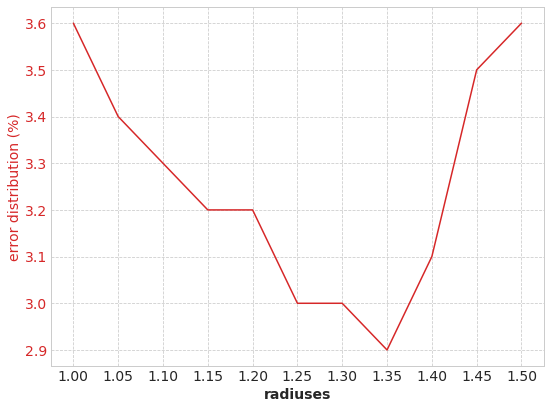

In [31]:
# Affichage
mpl.rcParams["font.size"] = 14
fig, ax1 = plt.subplots(figsize=(20.0/2.54, 15.0/2.54))

color = 'tab:red'
ax1.set_xlabel('radiuses',fontdict=dict(weight='bold'))
ax1.set_ylabel('error distribution (%)', color=color)
ax1.plot(gauss_radiuses, errors, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(linestyle='--')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.xticks(gauss_radiuses)
plt.show()

**Conclusion**
<br>Rajouter légèrement du flou dans les données d'entraînement permet d'augmenter significativement la performance du modèle.
<br>Le rayon optimal pour le filtre gaussien se situe entre  $r=1,2 ~ pixel$ et $r=1,5 ~ pixel$.
<br>Le niveau d'erreur est alors $50\%$ plus faible que sans pré-traitement.